# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Краткий план работы:

* Откройте файл с данными и изучите его.
* Разделите исходные данные на обучающую, валидационную и тестовую выборки.
* Исследуйте качество разных моделей, меняя гиперпараметры. 
* Проверьте качество модели на тестовой выборке.
* Дополнительное задание: проверьте модели на вменяемость.

## Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:
* 		сalls — количество звонков,
* 		minutes — суммарная длительность звонков в минутах,
* 		messages — количество sms-сообщений,
* 		mb_used — израсходованный интернет-трафик в Мб,
* 		is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## 1. Откройте и изучите файл

In [ ]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from termcolor import colored
import time
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Определяем болд
def bold(): 
    return "\033[1m"

def bold_end(): 
    return "\033[0m"

#Ставим формат для нумериков
pd.options.display.float_format = '{: >10.2f}'.format

In [ ]:
data_tariff = pd.read_csv('datasets/users_behavior.csv')

**Функция print_basic_info, для вывода информации о массиве, и его переменных.**

4 входных параметра

* base - название базы данных
* info - 1: вывод информации о массиве, другое: не вывод
* head - n: вывод примера базы (вывод n - строк), n < 1: не вывод
* describe - 1: вывод описания переменных массива, другое: не вывод        

In [ ]:
def print_basic_info(base, info, head, describe):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print( base.info())  
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())

In [ ]:
#Инфо
print_basic_info(data_tariff,1,5,1)

#### Вывод:

База состоит из 3214 кейсов. <br>
Все заполенные. Если клиент не пользовался услугой - стоит ноль.

Для анализа и построения модели потребуются все переменные (calls, minutes, messages, mb_used),<br> они все описывают поведение клиента тарифа. 

Тип тарифа лежит в переменной is_ultra. <br>
31% - выборки подключен к тарифу ultra, 69% - к тарифу smart

## 2. Разбейте данные на выборки

In [ ]:
#разбиваем на train и остальное
df_train, df_other = train_test_split(data_tariff, test_size=0.40, random_state=515093)

#разбиваем на тест и валид
df_valid, df_test = train_test_split(df_other, test_size=0.50, random_state=515093)

print("all sample",data_tariff.shape)
print("train sample",df_train.shape)
print("valid sample",df_valid.shape)
print("test sample",df_test.shape)

In [ ]:
# Проверим что равномерно разбилось. Насколько отличаются средние?
for column in data_tariff.columns:
    print(column,":", round(df_train[column].mean(),1), "vs", round(df_valid[column].mean(),1) ,"vs", round(df_test[column].mean(),1))

На первый взгляд разбилось достаточно равномерно

## 3. Исследуйте модели

In [ ]:
# определим какие переменные берем в анализ. В нашем случае все, кроме результата
features_train = df_train.drop(['is_ultra'], axis=1)
features_valid = df_valid.drop(['is_ultra'], axis=1)

#выделяем результат. переменная категориальная
target_train = df_train['is_ultra'] 
target_valid = df_valid['is_ultra'] 

#проверим
print("features_train shape",features_train.shape)
print("target_train shape",target_train.shape)

#проверим
print("features_valid shape",features_valid.shape)
print("target_valid shape",target_valid.shape)

### Вариант 1 **DecisionTreeClassifier**

Возьмем DecisionTreeClassifier и посмотрим как будут обучатся модели в зависимости от глубины. Посмотрим глубину от 1 до 11.

In [ ]:
def put_in_base(model_name, base_res, per, i, print_train):
    start_time = time.time()
    #проверим
    predictions_train = model_name.predict(features_train)
    predictions_valid = model_name.predict(features_valid)
    if print_train == 1:
        print(per,"="+bold(), str(i) + ": " + bold_end(),"accuracy_score - ", 
              bold()+colored("{0:.0%}".format(accuracy_score(target_train, predictions_train)),'blue'),
              bold_end()+ ", time - %s seconds" % round((time.time() - start_time),3))
    #в базу
    base_res.loc[i,'accuracy_score_train'] = accuracy_score(target_train, predictions_train)
    base_res.loc[i,'accuracy_score_valid'] = accuracy_score(target_valid, predictions_valid)
    return base_res


print(bold(),colored('try DecisionTreeClassifier: \n','green'),bold_end() )
#сделаем пустую базу
DTC_res = pd.DataFrame()
for i in range(1, 17):
    model_DTC = DecisionTreeClassifier(random_state=515093, max_depth=i)
    #примеряем
    model_DTC.fit(features_train, target_train)
    #загоняем в базу и распечатаем треин(если надо)
    DTC_res = put_in_base(model_DTC, DTC_res, 'max_depth', i , 1)


Есть ощущение, что после качественного скачка от max_depth = 1 в max_depth = 3 ( с 76% до 79%),  рост точности замедляется.  <br>
Где-то здесь может начаться переобучение модели. <br>
Чтобы понять, где начинаются проблемы положим данные train в базу, туда же добавим valid и сделаем график

**Функция lineplot_train_valid, для вывода графика точности по тренировочной и проверочной выборке, c с учетом переменного параметра**

3 входных параметра

* base - название базы данных
* title - название графика
* xlabel - лейбл для x (переменного параметра)  

In [ ]:
def max_as(base):
    m_as =  max(base['accuracy_score_valid'])
    for i in range(len(base)):
        if m_as ==  base.loc[i+1,'accuracy_score_valid']:
            return i + 1

def lineplot_train_valid(base , title, xlabel):
    plt.figure(figsize = (10,5)) 
    sns.set(style="whitegrid")
    sns.lineplot(data=base, palette="tab20", linewidth=2.5)
    plt.title(title, fontsize=15)
    plt.ylabel("accuracy_score %%")
    plt.xlabel(xlabel)
    plt.text(max_as(base) ,base.loc[max_as(base), 'accuracy_score_train'] + 
             0.02, "{0:.0%}".format(base.loc[max_as(base),'accuracy_score_train']), fontdict={'size':16},
             color='black')
    plt.text(max_as(base),base.loc[max_as(base), 'accuracy_score_valid'] - 
             0.06, "{0:.0%}".format(base.loc[max_as(base),'accuracy_score_valid']), 
             fontdict={'size':16}, color='grey')
    plt.ylim((0.5, 1.0)) 
    plt.show()

In [ ]:
#строим график
lineplot_train_valid(DTC_res,"DecisionTreeClassifier, точность с разной глубиной дерева\n","max_depth")

Модель начинает переобучатся на глубине 4 и выше. Оставляем модель с глубиной 3

In [ ]:
#финализируем модель
model_DTC = DecisionTreeClassifier(random_state=515093, max_depth=3)
model_DTC.fit(features_train, target_train)

### Вариант 2 **RandomForestClassifier**

Возьмем RandomForestClassifier и посмотрим сколько деревьев будет достаточно, max_depth пока оставим по умолчанию.

In [ ]:
#сделаем пустую базу
RFC_res = pd.DataFrame()
for i in range(1, 26):
    model_RFC = RandomForestClassifier(random_state=515093, n_estimators=i)
    #примеряем
    model_RFC.fit(features_train, target_train)
    #загоняем в базу и распечатаем треин(если надо)
    model_RFC = put_in_base(model_RFC, RFC_res, 'n_estimators', i , 0)

#строим график
lineplot_train_valid(RFC_res,"RandomForestClassifier, точность с разным количеством деревьев \n","n_estimators")

7 - должно быть достаточно. Теперь посмотрим max_depth.

In [ ]:
#сделаем пустую базу
RFC_res = pd.DataFrame()
for i in range(1, 10):
    model_RFC = RandomForestClassifier(random_state=515093, n_estimators=7, max_depth = i)
    #примеряем
    model_RFC.fit(features_train, target_train)
    #загоняем в базу и распечатаем треин(если надо)
    model_RFC = put_in_base(model_RFC, RFC_res, 'max_depth', i , 0)

#строим график
lineplot_train_valid(RFC_res,"RandomForestClassifier, точность с разной глубиной деревьев \n","max_depth")

max_depth - можем оставим 5. Дальше излишнее обучение

In [ ]:
#финализируем
model_RFC = RandomForestClassifier(random_state=515093, n_estimators=7, max_depth=5)
model_RFC.fit(features_train, target_train)

Модель перспективная. Можно еще чуть улучшить.
Посмотрим max_features от 1 до 4 - т.к. глубина деревьев у нас 5.

In [ ]:
#сделаем пустую базу
RFC_res = pd.DataFrame()
for i in range(1, 5):
    model_RFC = RandomForestClassifier(random_state=515093, n_estimators=7, max_depth = 5, max_features = i)
    #примеряем
    model_RFC.fit(features_train, target_train)
    #загоняем в базу и распечатаем треин(если надо)
    model_RFC = put_in_base(model_RFC, RFC_res, 'max_depth', i , 0)

#строим график
lineplot_train_valid(RFC_res,"RandomForestClassifier, точность с разной максимальной глубиной ветки дерева \n","max_features")

Не стоит менять. Оставим по умолчанию (2).

In [ ]:
#финализируем
model_RFC = RandomForestClassifier(random_state=515093, n_estimators=7, max_depth = 5)    
model_RFC.fit(features_train, target_train)

### Вариант 3 **LogisticRegression**

Посмотрим LogisticRegression. Без доп. параметров

In [ ]:
warnings.filterwarnings("ignore")

model_LR = LogisticRegression(random_state=515093)
model_LR.fit(features_train, target_train)
start_time = time.time()
predictions_train = model_LR.predict(features_train)
print("n_estimators =" + bold(),  str(i) + ": ",bold_end(),"accuracy_score - ",bold()+colored("{0:.0%}".format(accuracy_score(target_train, predictions_train)),'blue'), bold_end())
predictions_valid = model_LR.predict(features_valid)
print("n_estimators =" + bold(),  str(i) + ": ",bold_end(),"accuracy_score - ",bold()+colored("{0:.0%}".format(accuracy_score(target_valid, predictions_valid)),'blue'), bold_end()," time - %s seconds" % round((time.time() - start_time),3))

Точность меньше, чем у других моделей.

### Вариант 4 **KNeighborsClassifier**

Посмотрим на ближайших соседей. Проверим от 1 до 15

In [ ]:
#сделаем пустую базу
KNC_res = pd.DataFrame()
for i in range(1, 16):
    model_KNC = KNeighborsClassifier(n_neighbors=i)
    #примеряем
    model_KNC.fit(features_train, target_train)
    #загоняем в базу и распечатаем треин(если надо)
    model_KNC = put_in_base(model_KNC, KNC_res, 'n_neighbors', i , 0)

#строим график
lineplot_train_valid(KNC_res,"KNeighborsClassifier, точность с разным количеством соседей \n","n_neighbors")

Если будем использовать эту модель, то с n_neighbors = 6.

In [ ]:
#финализируем модель
model_KNC = KNeighborsClassifier(n_neighbors=6, p=2, metric='minkowski')
start_time = time.time()
model_KNC.fit(features_train, target_train)

### Выберем модель

In [ ]:
#сделаем таблицу моделей с финальными параметрами
models = pd.DataFrame()

def base_add(model_name, name ):
    models_train = pd.DataFrame()
    models_valid = pd.DataFrame()
    predictions_train = model_name.predict(features_train)
    predictions_valid = model_name.predict(features_valid)
    models_train.loc[name, 'accuracy_score'] = accuracy_score(target_train, predictions_train)
    models_valid.loc[name, 'accuracy_score'] = accuracy_score(target_valid, predictions_valid)
    models_train['sample'] = 'train'
    models_valid['sample'] = 'valid'
    models_train = models_train.append(models_valid)
    return models_train

models = models.append(base_add(model_RFC, 'RFC'))
models = models.append(base_add(model_KNC, 'KNC'))
models = models.append(base_add(model_DTC, 'DTC'))
models = models.append(base_add(model_LR, 'LR'))
models = models.reset_index()

In [ ]:
#выведем график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.barplot(data=models, palette="tab20", linewidth=2.5,  y="accuracy_score",hue="sample", x="index")
plt.title("Сравнение эффективности моделей ", fontsize=15)
plt.ylabel("accuracy_score %%")
plt.xlabel("Модели")

for i in range(0, len(models), 2):
    if i == 0:
        plt.text(i - 0.3 ,models.loc[i, 'accuracy_score'] + 0.01, "{0:.0%}".format(models.loc[i, 'accuracy_score']))
        plt.text(i + 0.1,models.loc[i+1, 'accuracy_score'] + 0.01, "{0:.0%}".format(models.loc[i+1, 'accuracy_score']))  
    if i != 0:
        plt.text((i / 2 - 0.3) ,models.loc[i, 'accuracy_score'] + 0.01, "{0:.0%}".format(models.loc[i, 'accuracy_score']))
        plt.text((i / 2 + 0.1),models.loc[i+1, 'accuracy_score'] + 0.01, "{0:.0%}".format(models.loc[i+1, 'accuracy_score'])) 
plt.ylim((0, 1.2))   
plt.show()

У всех моделей кроме LogisticRegression хороший показатель accuracy_score
#### Будем использовать модель Random Forest - она может дать точность чуть выше. 

## 4. Проверьте модель на тестовой выборке

In [ ]:
#тестовые входные данные
features_test = df_test.drop(['is_ultra'], axis=1)

#выделяем результат.
target_test = df_test['is_ultra'] 

#проверим 
print("features_test shape",features_test.shape)
print("target_test shape",target_test.shape)

In [ ]:
#Проверим точность модели.
print(bold(),colored('Random Forest Classifier model: \n','green'),bold_end() )

predictions_valid= model_RFC.predict(features_valid)
print(bold(),  "accuracy_score - on valid sample: "+ colored("{0:.000%}".format(accuracy_score(target_valid, predictions_valid)),'blue'),bold_end())
predictions_test= model_RFC.predict(features_test)
print(bold(),  "accuracy_score - on test sample: "+ colored("{0:.000%}".format(accuracy_score(target_test, predictions_test)),'blue'),bold_end())


#### Выводы:

Точность модели на тестовой выборке - 80%, что больше минимального порога по ТЗ в 75%

## 5. (бонус) Проверьте модели на адекватность

Адекватной может считаться модель:
* Которая соответствует ТЗ. А именно в нашем случае имеет accuracy_score в 75% и выше. Наша модель подходит.
* Не противоречит здравому смыслу и нашим гипотезам. Для этого мы посмотрим на данные. В частности на профили респондентов, а также на  распределение тарифов.
* Также, точность не должна сильно скакать в зависимости от выборки. Поэтому будем потихоньку добавлять выборку и смотреть на точность.

**Проверка на логичность**

In [25]:
print(bold(),"% is_ultra in test sample: target",colored(round(target_test.mean(),2),'blue')+bold(),"VS predictions",
      colored(round(predictions_test.mean() ,2),'blue'),bold_end())

 % is_ultra in test sample: target 0.3 VS predictions 0.17 


Есть расхождение в доле клиентов в пользу дешевого тарифа smart.<br>
Однако это объяснимо, т.к. в предыдущем исследовании профиля клиентов как было установлено, что часть клиентов ultima схожи по профилю c клиентами smart и используют схожий обьем услуг (при большем объеме предоставляемых).

In [26]:
#подольем информацию о результатах предсказания к кейсам
df_test = df_test.reset_index()
df_test['predictions'] = predictions_test
df_test['goal'] = df_test['predictions'] == df_test['is_ultra']

In [27]:
#сделаем единую базу 
df_test['type'] = 'target'

test = features_test
test['is_ultra'] = predictions_test
test['type'] = 'predictions'
test.reset_index()

test_data = df_test.append(test)

#проверяем, что корректно слилось
print("predictions, is_ultra - ",test_data[test_data['type'] == 'predictions']['is_ultra'].mean())
print("target, is_ultra - ",test_data[test_data['type'] == 'target']['is_ultra'].mean())

predictions, is_ultra -  0.17262830482115085
target, is_ultra -  0.30171073094867806


**Сделаем функцию ft_hist_comp(base, name, cross, title, labelx, labely), для вывода графика  в разрезе**

6 входных параметров

* base - название базы данных
* name - имя переменной в базе
* cross - имя переменной, в разрезе которой смотрим
* title - название таблицы
* labelx - лейбл X
* labely - лейбл Y

In [28]:
def ft_hist_comp(base, name, cross,title,labelx, labely):
    plt.figure(figsize = (10,5)) 
    for i in base[cross].unique():
        base[base[cross] == i][name].hist(bins = 50, label = 
                                              str(i), alpha=0.7, density=True)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(title, fontsize=15) 
    plt.legend()
    plt.show()

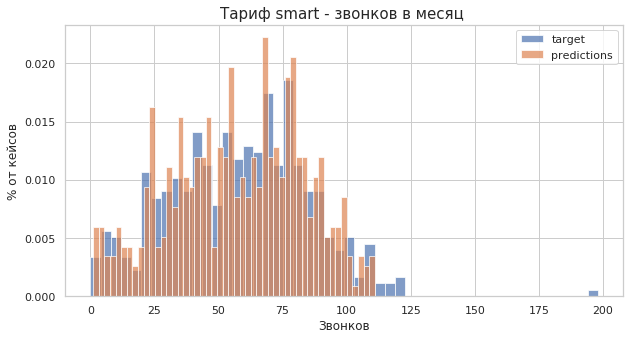

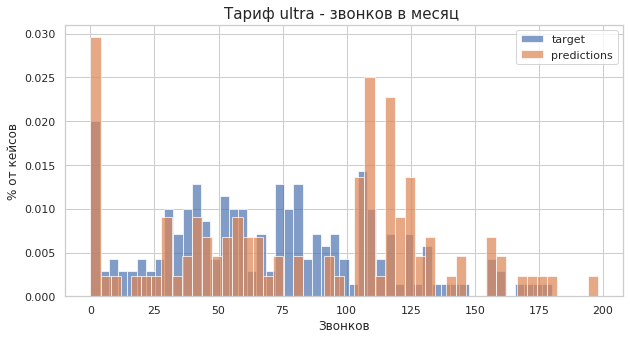

In [29]:
ft_hist_comp(test_data.query('is_ultra == 0'), name = 'calls', cross = 'type',
             title = 'Тариф smart - звонков в месяц ',
           labely = '% от кейсов', labelx = 'Звонков')

ft_hist_comp(test_data.query('is_ultra == 1'), name = 'calls', cross = 'type',
             title ='Тариф ultra - звонков в месяц ',
           labely = '% от кейсов', labelx = 'Звонков')

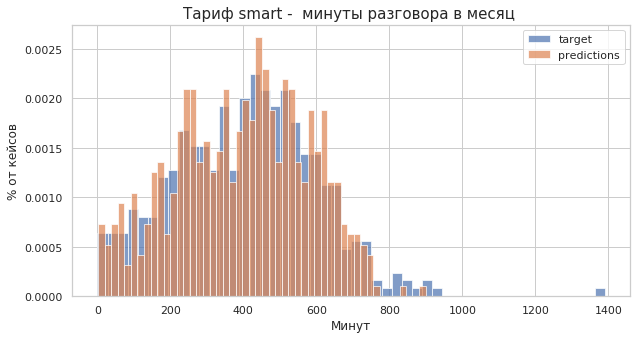

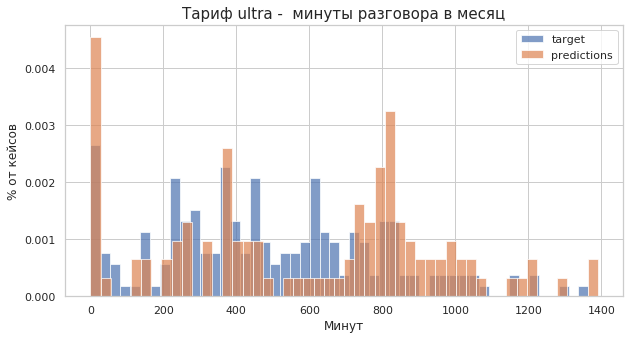

In [30]:
ft_hist_comp(test_data.query('is_ultra == 0'), name = 'minutes', cross = 'type',
             title ='Тариф smart -  минуты разговора в месяц ',
           labely = '% от кейсов', labelx = 'Минут')

ft_hist_comp(test_data.query('is_ultra == 1'), name = 'minutes', cross = 'type',
             title ='Тариф ultra -  минуты разговора в месяц',
           labely = '% от кейсов', labelx = 'Минут')

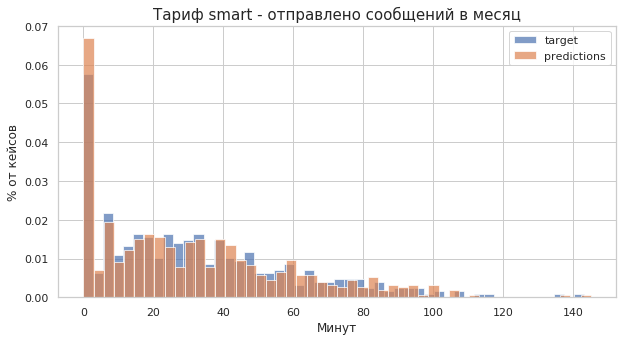

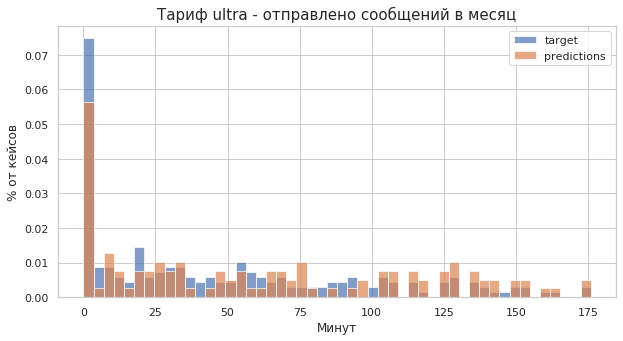

In [31]:
ft_hist_comp(test_data.query('is_ultra == 0'), name = 'messages', cross = 'type',
             title ='Тариф smart - отправлено сообщений в месяц',
           labely = '% от кейсов', labelx = 'Минут')

ft_hist_comp(test_data.query('is_ultra == 1'), name = 'messages', cross = 'type',
             title ='Тариф ultra - отправлено сообщений в месяц',
           labely = '% от кейсов', labelx = 'Минут')

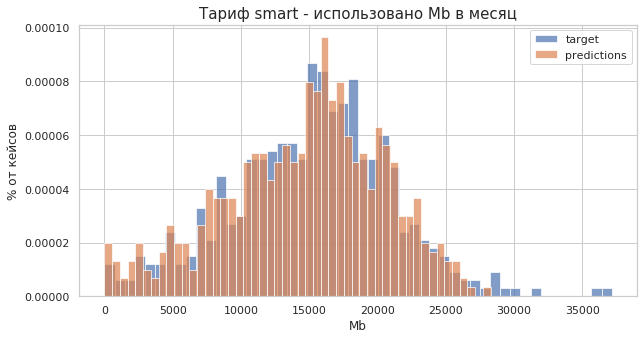

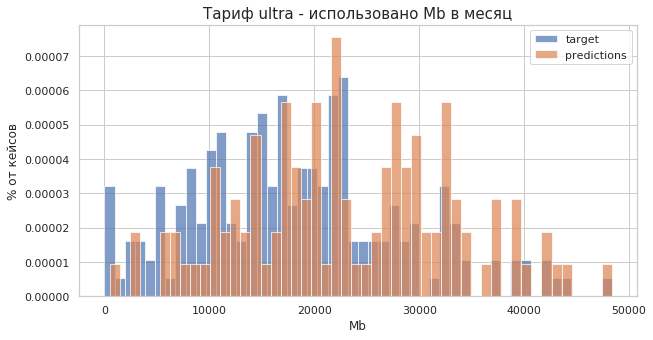

In [32]:
ft_hist_comp(test_data.query('is_ultra == 0'), name = 'mb_used', cross = 'type',
             title ='Тариф smart - использовано Mb в месяц',
           labely = '% от кейсов', labelx = 'Mb')

ft_hist_comp(test_data.query('is_ultra == 1'), name = 'mb_used', cross = 'type',
             title ='Тариф ultra - использовано Mb в месяц',
           labely = '% от кейсов', labelx = 'Mb')

Профили реальных и предсказанных пользователей тарифа в схожи. Однако меньшее пользование услугами  пользователей ultra повышает шанс быть отнесенным к пользователям тарифа smart

**Зависимость от объема выборки**

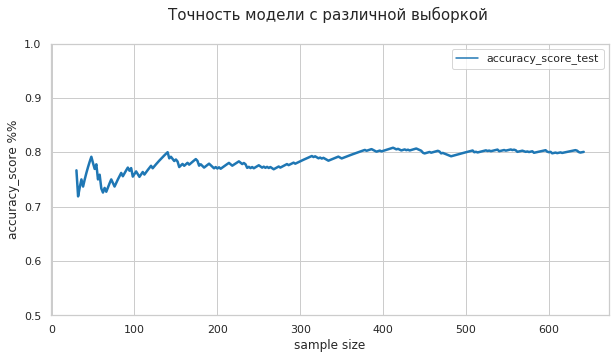

In [33]:
**Зависимость от объема выборки**

#делаем базу. добавляем по 2 кейса увеличивая семпл
base_min = pd.DataFrame()
for i in range(30,len(predictions_test),2):
    base_min.loc[i,'accuracy_score_test'] = accuracy_score(target_test[0:i], predictions_test[0:i])

#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.lineplot(data=base_min, palette="tab20", linewidth=2.5)
plt.title("Точность модели с различной выборкой \n", fontsize=15)
plt.ylabel("accuracy_score %%")
plt.xlabel("sample size")
plt.ylim((0.5, 1.0)) 
plt.show()

Модель не очень стабильна на небольшой выборке, что ожидаемо. <br>В целом показатель точности не сильно колеблется, плавно улучшается и далее стабилизируется.

#### Вывод:

**Модель можем считать адекватной :**

- [x] Соответвует ТЗ. <br> *А именно в имеет accuracy_score в 75% и выше.*
- [x] Не противоречит здравому смыслу. <br>
*Есть расхождение в доле клиентов в пользу дешевого тарифа smart.
Однако это объяснимо, т.к. в предыдущем исследовании профиля клиентов как было установлено, что часть клиентов ultima схожи по профилю c клиентами smart и используют схожий обьем услуг, при большем объеме их предоставления в тарифе.*<br>
*Профили клиентов тарифа на основе тестовых данных, не сильно отличаются по сравнению с предполагаемыми клиентами тарифа*
- [x] Не сильно зависит от объема выборки. <br>*При увеличении обьем показатели модели плавно улучшается и далее стабилизируется.*

#### Экспортируем модель 

In [34]:
# сохраняем модель для дальнейшей работы вне книги
joblib.dump(model_RFC, 'model_RFC_for_mobile_tariff_accuracy_80.joblib')

['model_RFC_for_mobile_tariff_accuracy_80.joblib']

## Вывод:

**На основе данные о поведении клиентов, которые перешли с устаревших на актуальные тарифы «Смарт» или «Ультра» была построена модель для задачи классификации, которая подбирает подходящий тариф с 80% вероятностью.**

**Модель построена на основе информации о поведении клиентов за месяц:**
    
* сalls — количество звонков
* minutes — суммарная длительность звонков в минутах
* messages — количество sms-сообщений
* mb_used — израсходованный интернет-трафик в Мб.

**Классификация производится с помощью "Random Forest Classifier", c параметрами n_estimators (количество деревьев) - 7 и max_depth(глубина дерева) - 5**



Вы можете скачать модель с названием <font color='blue'>  **model_RFC_for_mobile_tariff_accuracy_80.joblib**
</font>

**Кодирование результатов:**
<font color='blue'> 
* **0 - тариф Смарт**
* **1 - тариф Ультра**
    






## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
